In [1]:
#external packages
import numpy as np
import math
from astropy import units as u
import astropy.coordinates as coord
from astropy.table import Table
from astropy.io import fits
import time
from numpy.lib.recfunctions import append_fields
from astropy.cosmology import FlatLambdaCDM,Planck15
from matplotlib.backends.backend_pdf import PdfPages
import sys
import random
from matplotlib.ticker import AutoMinorLocator
from matplotlib import gridspec
%load_ext autoreload

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

sys.path.append('/home/almhatre/data')

In [2]:
import AGNclustering.kNN_functions as k
from AGNclustering.KNN_stuff import CDFkNN_rp_pi
from AGNclustering.kNN_error import generate_distinct_colors, kNN_ratio_error, block_test, kNN_chi_squared,kNN_diff_error,chop_cdf, angular_chop_cdf
from AGNclustering.utils import z_to_cdist
from AGNclustering.wppi_utils import control_mult_var,control_var
from AGNclustering.angular_kNN import CDFkNN_theta
import AGNclustering.BASS_randoms as rand

In [3]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
data_directory = '/home/almhatre/data/BASS/'
cat = Table.read(data_directory + 'data_dr2.csv',format='csv')
agnt =np.array(cat)
agn = agnt[ (agnt['L210']>42.5) & (agnt['z']>.01)&(agnt['z']<=.1) ]
t = Table.read(data_directory +'2mrs_noAGN.csv',format='csv')
gal =np.array(t)
gal=gal[(gal['z']>.01)&(gal['z']<=.1)] #Limit redshifts to same range as AGN
agn.dtype.names

('col0',
 'bat_index',
 'Counterpart',
 'Type',
 'z',
 'Mbh',
 'Method',
 'Edd_rat',
 'L_edd',
 'L_bol',
 'NH',
 'L210',
 'ra',
 'dec',
 'L14195',
 'AGN',
 'flux',
 'Snu_1',
 'Snu_6',
 'Morphology',
 'log_Ms',
 'Lir_sf')

In [4]:
# arand1 = rand.genrand(agn,2,cosmo,width=.2,scoords='galactic',use_BASS_sens_map=True,\
#                      data_path=data_directory,plot=True,plot_filename=None)
# arand1 = arand1[:len(agn)]

# arand2 = rand.genrand(agn,2,cosmo,width=.2,scoords='galactic',use_BASS_sens_map=True,\
#                      data_path=data_directory,plot=True,plot_filename=None)
# arand2 = arand2[:len(agn)]

# arand3 = rand.genrand(agn,2,cosmo,width=.2,scoords='galactic',use_BASS_sens_map=True,\
#                      data_path=data_directory,plot=True,plot_filename=None)
# arand3 = arand3[:len(agn)]

# arand4 = rand.genrand(agn,2,cosmo,width=.2,scoords='galactic',use_BASS_sens_map=True,\
#                      data_path=data_directory,plot=True,plot_filename=None)
# arand4 = arand4[:len(agn)]

# arand5 = rand.genrand(agn,2,cosmo,width=.2,scoords='galactic',use_BASS_sens_map=True,\
#                      data_path=data_directory,plot=True,plot_filename=None)
# arand5 = arand5[:len(agn)]
# #100: 100X randoms as AGN

In [143]:
agn = agnt[ (agnt['L210']>42.5) & (agnt['z']>.01)&(agnt['z']<=.1) ]
gal =np.array(t)
gal=gal[(gal['z']>.01)&(gal['z']<=.1)] #Limit redshifts to same range as AGN

div = 33
redshift0 = 0
redshift33 = np.percentile(agn['z'], div)
redshift66 = np.percentile(agn['z'], div*2)
redshift99 = np.percentile(agn['z'], 100)

nonzero = ( (agn['z'] > redshift0) & (agn['z'] <= redshift33) )
lowredshift = agn[nonzero]

nonzero = ( (agn['z'] > redshift33) & (agn['z'] <= redshift66) )
midredshift = agn[nonzero]

nonzero = ( (agn['z'] > redshift66) & (agn['z'] <= redshift99) )
highredshift = agn[nonzero]

zmin = (highredshift['z'].min())
zmax = (highredshift['z'].max())

gal=gal[(gal['z']>zmin)&(gal['z']<=zmax)]

In [144]:
# For limiting redshift samplings
agnmass = highredshift

# agnmass = agn
# gal =np.array(t)
# gal=gal[(gal['z']>.01)&(gal['z']<=.1)] #Limit redshifts to same range as AGN


nonzero=(agnmass["Mbh"]>0)
agnmass=agnmass[nonzero]
zbins=np.arange(0.01,.11,.01)
percentile=33

# In order to control for Edd_rat
nonzero=((agnmass["Edd_rat"]>0) & (agnmass["Edd_rat"]<1))
agnmass = agnmass[nonzero]
edd_rat_bins = np.logspace(-3, 0, 10)
             

# stmin=np.min(agnmass['log_Ms'][agnmass['log_Ms']>8])
# stmax=np.max(agnmass['log_Ms'][agnmass['log_Ms']>8])
# increm=(stmax-stmin)/5
# msbins=np.arange(stmin,stmax+increm,increm)

# increm=(stmax-stmin)/9
# msbinsmod=np.arange(stmin,stmax+increm,increm)


stmin=np.min(agnmass['Mbh'][agnmass['Mbh']>0])
stmax=np.max(agnmass['Mbh'][agnmass['Mbh']>0])
increm=(stmax-stmin)/9
massbins=np.arange(stmin,stmax+increm,increm)

In [145]:
%autoreload 2

#Controlling for 2 vars
l, m, up = control_mult_var(agn=agnmass,bins1=zbins,bins2=massbins,control1='z',control2='Mbh',var='Edd_rat',percentile=40)

#Controlling for a singular var
# l, m, up = control_var(agn=agnmass,bins=zbins,control='z',var='Mbh',percentile=percentile)


In [146]:
## Code Block for doing random split of AGN catalog ##

# shuffled_indices = np.random.permutation(agnmass.shape[0])

# # Determine the split point (half in this case)
# split_point = len(agnmass) // 2

# # middle = np.median(agnmass['ra'])

# # l = agnmass[agnmass['ra'] < middle]
# # up = agnmass[agnmass['ra'] > middle]

# # Use the shuffled indices to create two new arrays
# l = agnmass[shuffled_indices[:split_point]]
# up = agnmass[shuffled_indices[split_point:]]

In [147]:
# ## Black hole mass distribution w.r.t. redshift ##

# # Set up figure layout with an additional column for the right-side histogram
# fig = plt.figure(figsize=(12, 8))
# gs = gridspec.GridSpec(2, 2, width_ratios=[5, 1], height_ratios=[1, 4], hspace=0.05, wspace=0.05)

# # Assign subplots
# ax0 = plt.subplot(gs[0, 0])  # For the top histogram (redshift distribution)
# ax1 = plt.subplot(gs[1, 0], sharex=ax0)  # For the main scatter plot
# ax2 = plt.subplot(gs[1, 1])  # For the right-side histogram (black hole mass distribution)

# # Top histogram (redshift distribution)
# ax0.hist(l['z'], bins=zbins, histtype='step', label='Low Bin', density=False)
# ax0.hist(up['z'], bins=zbins, histtype='step', label='High Bin', density=False)
# ax0.set_xticks([])  # Hide x-axis labels

# # Main scatter plot (black hole mass vs. redshift)
# ax1.scatter(up['z'], up['Mbh'], color='maroon', label='Large MBH', alpha=0.7)
# ax1.scatter(l['z'], l['Mbh'], color='cyan', label='Small MBH', alpha=0.7)
# ax1.set_xlabel('Redshift (z)')
# ax1.set_ylabel('Log10(MBH/M)')
# ax1.set_xscale("linear")
# ax1.legend()

# # Right-side histogram (black hole mass distribution) with horizontal orientation
# ax2.hist(l['Mbh'], bins=massbins, orientation='horizontal', histtype='step', label='Low Bin', density=False)
# ax2.hist(up['Mbh'], bins=massbins, orientation='horizontal', histtype='step', label='High Bin', density=False)
# ax2.set_xticks([])  # Hide x-axis labels
# ax2.set_yticks([])  # Also hide y-axis labels for the right-side histogram

# # Here, we disable the grid by not calling ax1.grid()
# # Adjustments to the scatter plot ticks for clarity
# ax1.minorticks_on()
# ax1.tick_params(which='minor', direction='in')
# ax1.tick_params(which='major', direction='in')

# plt.show()


In [148]:
# ## Black hole mass distribution w.r.t. Eddington Ratio ##

# # Set up figure layout with an additional column for the right-side histogram
# fig = plt.figure(figsize=(12, 8))
# gs = gridspec.GridSpec(2, 2, width_ratios=[5, 1], height_ratios=[1, 4], hspace=0.05, wspace=0.05)

# # Assign subplots
# ax0 = plt.subplot(gs[0, 0])  # For the top histogram (Eddington ratio distribution)
# ax1 = plt.subplot(gs[1, 0], sharex=ax0)  # For the main scatter plot
# ax2 = plt.subplot(gs[1, 1])  # For the right-side histogram (black hole mass distribution)

# # Top histogram (Eddington ratio distribution)
# ax0.hist(l['Edd_rat'], bins=edd_rat_bins, histtype='step', label='Low Bin', density=False)
# ax0.hist(up['Edd_rat'], bins=edd_rat_bins, histtype='step', label='High Bin', density=False)
# ax0.set_xticks([])  # Hide x-axis labels

# # Main scatter plot (black hole mass vs. Eddington ratio)
# ax1.scatter(up['Edd_rat'], up['Mbh'], color='maroon', label='Large MBH', alpha=0.7)
# ax1.scatter(l['Edd_rat'], l['Mbh'], color='cyan', label='Small MBH', alpha=0.7)
# ax1.set_xlabel('Eddington Ratio')
# ax1.set_ylabel('Log10(MBH/M)')
# ax1.set_xscale("log")
# ax1.legend()

# # Right-side histogram (black hole mass distribution) with horizontal orientation
# ax2.hist(l['Mbh'], bins=massbins, orientation='horizontal', histtype='step', label='Low Bin', density=False)
# ax2.hist(up['Mbh'], bins=massbins, orientation='horizontal', histtype='step', label='High Bin', density=False)
# ax2.set_xticks([])  # Hide x-axis labels
# ax2.set_yticks([])  # Also hide y-axis labels for the right-side histogram

# # Adjustments to the scatter plot ticks for clarity
# ax1.minorticks_on()
# ax1.tick_params(which='minor', direction='in')
# ax1.tick_params(which='major', direction='in')

# plt.show()


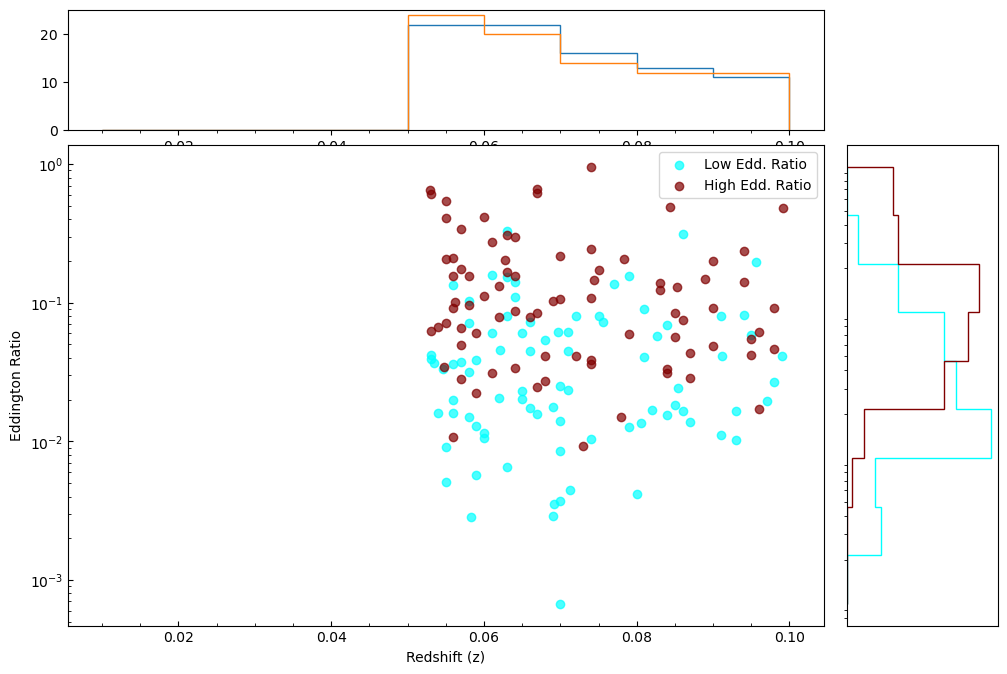

In [149]:
## Eddington Ratio distribution w.r.t. redshift ##

# Set up figure layout with an additional column for the right-side histogram
fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(2, 2, width_ratios=[5, 1], height_ratios=[1, 4], hspace=0.05, wspace=0.05)

# Assign subplots
ax0 = plt.subplot(gs[0, 0])  # For the top histogram (Eddington ratio distribution)
ax1 = plt.subplot(gs[1, 0], sharex=ax0)  # For the main scatter plot
ax2 = plt.subplot(gs[1, 1])  # For the right-side histogram (Eddington ratio distribution)

# Top histogram (Eddington ratio distribution)
ax0.hist(l['z'], bins=zbins, histtype='step', label='Low Bin', density=False)
ax0.hist(up['z'], bins=zbins, histtype='step', label='High Bin', density=False)
# ax0.set_xticks([])  # Hide x-axis labels

# Main scatter plot (Eddington ratio vs. redshift)
# Note: Assuming 'Edd_rat' exists in your data and represents the Eddington ratio
ax1.scatter(l['z'], l['Edd_rat'], color='cyan', label='Low Edd. Ratio', alpha=0.7)
ax1.scatter(up['z'], up['Edd_rat'], color='maroon', label='High Edd. Ratio', alpha=0.7)
ax1.set_xlabel('Redshift (z)')
ax1.set_ylabel('Eddington Ratio')
ax1.set_yscale("log")
ax1.legend()

# Right-side histogram (Eddington ratio distribution) with horizontal orientation
# Using 'edd_rat_bins' for the binning of Eddington ratio values
ax2.hist(l['Edd_rat'], bins=edd_rat_bins, orientation='horizontal', histtype='step',color='cyan', label='Low Bin', density=False)
ax2.hist(up['Edd_rat'], bins=edd_rat_bins, orientation='horizontal', histtype='step', color='maroon', label='High Bin', density=False)
ax2.set_yscale("log")
ax2.set_xticks([])  # Hide x-axis labels
ax2.set_yticks([])  # Also hide y-axis labels for the right-side histogram


# Adjustments to the scatter plot ticks for clarity
ax1.minorticks_on()
ax1.tick_params(which='minor', direction='in')
ax1.tick_params(which='major', direction='in')

plt.show()


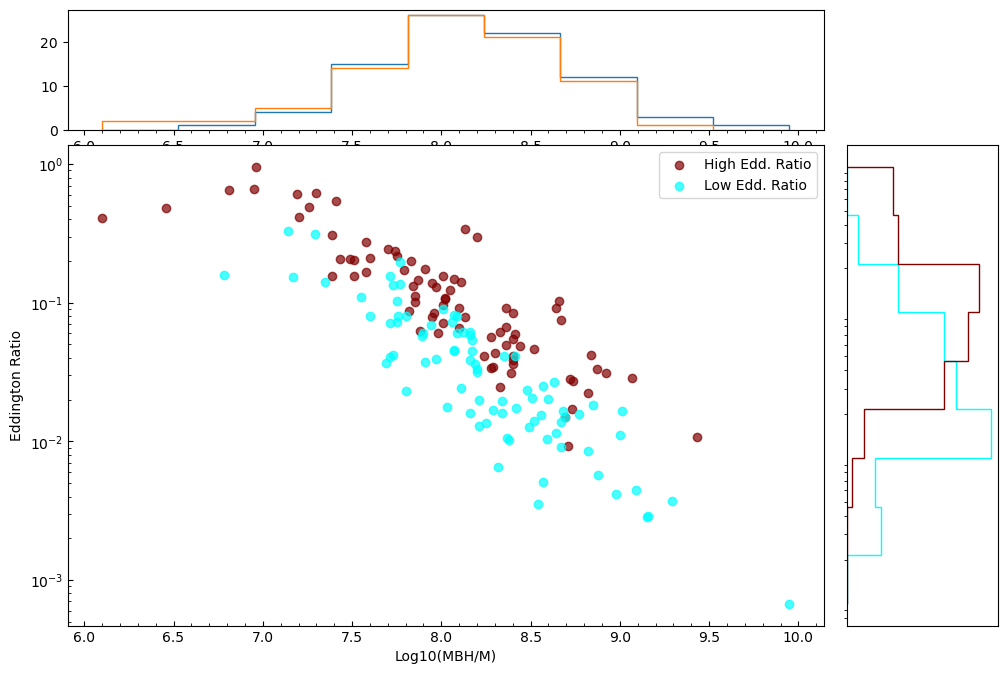

In [150]:
## Eddington Ratio distribution w.r.t. black hole mass ##

# Set up figure layout with an additional column for the right-side histogram
fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(2, 2, width_ratios=[5, 1], height_ratios=[1, 4], hspace=0.05, wspace=0.05)

# Assign subplots
ax0 = plt.subplot(gs[0, 0])  # For the top histogram (Eddington ratio distribution)
ax1 = plt.subplot(gs[1, 0], sharex=ax0)  # For the main scatter plot
ax2 = plt.subplot(gs[1, 1])  # For the right-side histogram (Eddington ratio distribution)

# Top histogram (Eddington ratio distribution)
ax0.hist(l['Mbh'], bins=massbins, histtype='step', label='Low Bin', density=False)
ax0.hist(up['Mbh'], bins=massbins, histtype='step', label='High Bin', density=False)
ax0.set_xticks([])  # Hide x-axis labels

# Main scatter plot (Eddington ratio vs. redshift)
# Note: Assuming 'Edd_rat' exists in your data and represents the Eddington ratio
ax1.scatter(up['Mbh'], up['Edd_rat'], color='maroon', label='High Edd. Ratio', alpha=0.7)
ax1.scatter(l['Mbh'], l['Edd_rat'], color='cyan', label='Low Edd. Ratio', alpha=0.7)
ax1.set_xlabel('Log10(MBH/M)')
ax1.set_ylabel('Eddington Ratio')
ax1.set_yscale("log")
ax1.set_xscale("linear")
ax1.legend()

# Right-side histogram (Eddington ratio distribution) with horizontal orientation
# Using 'edd_rat_bins' for the binning of Eddington ratio values
ax2.hist(l['Edd_rat'], bins=edd_rat_bins, orientation='horizontal', histtype='step',color='cyan', label='Low Bin', density=False)
ax2.hist(up['Edd_rat'], bins=edd_rat_bins, orientation='horizontal', histtype='step',color='maroon', label='High Bin', density=False)
ax2.set_yscale("log")
ax2.set_xticks([])  # Hide x-axis labels
ax2.set_yticks([])  # Also hide y-axis labels for the right-side histogram


# Adjustments to the scatter plot ticks for clarity
ax1.minorticks_on()
ax1.tick_params(which='minor', direction='in')
ax1.tick_params(which='major', direction='in')

plt.show()


In [157]:
kneighbors = np.array([1,2,3,4,5,6,7])

degree_min = 0.5
degree_max = 1.2

anglestemp = np.linspace(degree_min*np.pi/180.0, degree_max*np.pi/180.0, 4)

anglestemp = np.insert(anglestemp, 0, 0*np.pi/180.0)
anglestemp = np.insert(anglestemp, len(anglestemp), 1.5*np.pi/180.0)


angles = anglestemp[:-1]
angles = angles[1:]


linear_angle_adjust = 0

# randtemp1, randerrtemp1, covrand1 = k.angular_kNN_wrapper(anglestemp, arand1, gal, kneighbors,
#                                                              angleslist, concatenate = True, m=7)

# randtemp2, randerrtemp2, covrand2 = k.angular_kNN_wrapper(anglestemp, arand2, gal, kneighbors,
#                                                              angleslist, concatenate = True, m=7)

# randtemp3, randerrtemp3, covrand3 = k.angular_kNN_wrapper(anglestemp, arand3, gal, kneighbors,
#                                                              angleslist, concatenate = True, m=7)

# randtemp4, randerrtemp4, covrand4 = k.angular_kNN_wrapper(anglestemp, arand4, gal, kneighbors,
#                                                              angleslist, concatenate = True, m=7)

# randtemp5, randerrtemp5, covrand5 = k.angular_kNN_wrapper(anglestemp, arand5, gal, kneighbors,
#                                                              angleslist, concatenate = True, m=7)

outputhightemp, errhightemp, covhigh = k.angular_kNN_wrapper(anglestemp, up, gal, kneighbors,
                                                             linear_angle_adjust, concatenate = True, m=7)
outputlowtemp, errlowtemp, covlow =  k.angular_kNN_wrapper(anglestemp, l, gal, kneighbors,
                                                             linear_angle_adjust, concatenate = True, m=7)

Ngal 3724 Nrand 82 7
build tree 0.0025529861450195312
query 0.0015578269958496094
  kdtree tot 0.0041446685791015625
(82, 7) [0.         0.         0.00872665 0.01279908 0.01687152 0.02094395
 0.02617994]
  cdf 0.0007541179656982422
Ngal 3724 Nrand 82 7
build tree 0.0018205642700195312
query 0.0031015872955322266
  kdtree tot 0.004972696304321289
(82, 7) [0.         0.         0.01385269 0.02031728 0.02678186 0.03324645
 0.04155806]
  cdf 0.0014560222625732422
Ngal 3724 Nrand 82 7
build tree 0.005187273025512695
query 0.0031180381774902344
  kdtree tot 0.008358955383300781
(82, 7) [0.         0.         0.01815215 0.02662316 0.03509417 0.04356517
 0.05445647]
  cdf 0.0006394386291503906
Ngal 3724 Nrand 82 7
build tree 0.001817464828491211
query 0.0014994144439697266
  kdtree tot 0.0033452510833740234
(82, 7) [0.         0.         0.02198977 0.03225166 0.04251356 0.05277545
 0.06596931]
  cdf 0.0006067752838134766
Ngal 3724 Nrand 82 7
build tree 0.0017850399017333984
query 0.0014944076

  cdf 0.00171661376953125
Ngal 3665 Nrand 82 7
build tree 0.0017232894897460938
query 0.0019614696502685547
  kdtree tot 0.003727436065673828
(82, 7) [0.         0.         0.02881475 0.04226163 0.05570852 0.0691554
 0.08644425]
  cdf 0.0007052421569824219
Ngal 3665 Nrand 82 7
build tree 0.0017132759094238281
query 0.0014495849609375
  kdtree tot 0.0031909942626953125
(82, 7) [0.         0.         0.03193347 0.04683575 0.06173804 0.07664032
 0.0958004 ]
  cdf 0.0006005764007568359
7 / 49
Ngal 3709 Nrand 82 7
build tree 0.0017375946044921875
query 0.0013437271118164062
  kdtree tot 0.0031249523162841797
(82, 7) [0.         0.         0.00872665 0.01279908 0.01687152 0.02094395
 0.02617994]
  cdf 0.0006403923034667969
Ngal 3709 Nrand 82 7
build tree 0.001669168472290039
query 0.0013661384582519531
  kdtree tot 0.0030612945556640625
(82, 7) [0.         0.         0.01385269 0.02031728 0.02678186 0.03324645
 0.04155806]
  cdf 0.0005977153778076172
Ngal 3709 Nrand 82 7
build tree 0.0016710

query 0.0014128684997558594
  kdtree tot 0.0031540393829345703
(82, 7) [0.         0.         0.03193347 0.04683575 0.06173804 0.07664032
 0.0958004 ]
  cdf 0.0007634162902832031
14 / 49
Ngal 3698 Nrand 82 7
build tree 0.0017347335815429688
query 0.0014193058013916016
  kdtree tot 0.0031816959381103516
(82, 7) [0.         0.         0.00872665 0.01279908 0.01687152 0.02094395
 0.02617994]
  cdf 0.0006396770477294922
Ngal 3698 Nrand 82 7
build tree 0.001653909683227539
query 0.0014338493347167969
  kdtree tot 0.0031135082244873047
(82, 7) [0.         0.         0.01385269 0.02031728 0.02678186 0.03324645
 0.04155806]
  cdf 0.0005512237548828125
Ngal 3698 Nrand 82 7
build tree 0.0016574859619140625
query 0.0014104843139648438
  kdtree tot 0.003094911575317383
(82, 7) [0.         0.         0.01815215 0.02662316 0.03509417 0.04356517
 0.05445647]
  cdf 0.0005714893341064453
Ngal 3698 Nrand 82 7
build tree 0.0016672611236572266
query 0.0013790130615234375
  kdtree tot 0.003072500228881836


query 0.0014243125915527344
  kdtree tot 0.0031309127807617188
(82, 7) [0.         0.         0.01385269 0.02031728 0.02678186 0.03324645
 0.04155806]
  cdf 0.0007314682006835938
Ngal 3716 Nrand 82 7
build tree 0.001665353775024414
query 0.0014035701751708984
  kdtree tot 0.003097057342529297
(82, 7) [0.         0.         0.01815215 0.02662316 0.03509417 0.04356517
 0.05445647]
  cdf 0.0005812644958496094
Ngal 3716 Nrand 82 7
build tree 0.0017130374908447266
query 0.0014214515686035156
  kdtree tot 0.0031614303588867188
(82, 7) [0.         0.         0.02198977 0.03225166 0.04251356 0.05277545
 0.06596931]
  cdf 0.0005774497985839844
Ngal 3716 Nrand 82 7
build tree 0.0016903877258300781
query 0.0013761520385742188
  kdtree tot 0.0030922889709472656
(82, 7) [0.         0.         0.02551687 0.03742474 0.04933261 0.06124048
 0.0765506 ]
  cdf 0.0005743503570556641
Ngal 3716 Nrand 82 7
build tree 0.0016727447509765625
query 0.0014011859893798828
  kdtree tot 0.0030999183654785156
(82, 7)

query 0.00140380859375
  kdtree tot 0.0031189918518066406
(82, 7) [0.         0.         0.01815215 0.02662316 0.03509417 0.04356517
 0.05445647]
  cdf 0.000982046127319336
Ngal 3709 Nrand 82 7
build tree 0.0016808509826660156
query 0.0014903545379638672
  kdtree tot 0.0032002925872802734
(82, 7) [0.         0.         0.02198977 0.03225166 0.04251356 0.05277545
 0.06596931]
  cdf 0.0006377696990966797
Ngal 3709 Nrand 82 7
build tree 0.0016944408416748047
query 0.001397848129272461
  kdtree tot 0.003120899200439453
(82, 7) [0.         0.         0.02551687 0.03742474 0.04933261 0.06124048
 0.0765506 ]
  cdf 0.0005981922149658203
Ngal 3709 Nrand 82 7
build tree 0.0016634464263916016
query 0.0014052391052246094
  kdtree tot 0.0030975341796875
(82, 7) [0.         0.         0.02881475 0.04226163 0.05570852 0.0691554
 0.08644425]
  cdf 0.0005924701690673828
Ngal 3709 Nrand 82 7
build tree 0.0016636848449707031
query 0.0013980865478515625
  kdtree tot 0.0030884742736816406
(82, 7) [0.      

query 0.001392364501953125
  kdtree tot 0.0031147003173828125
(81, 7) [0.         0.         0.02881475 0.04226163 0.05570852 0.0691554
 0.08644425]
  cdf 0.0007584095001220703
Ngal 3697 Nrand 81 7
build tree 0.0016603469848632812
query 0.001367807388305664
  kdtree tot 0.003055572509765625
(81, 7) [0.         0.         0.03193347 0.04683575 0.06173804 0.07664032
 0.0958004 ]
  cdf 0.0005745887756347656
36 / 49
Ngal 3697 Nrand 81 7
build tree 0.001703023910522461
query 0.0013537406921386719
  kdtree tot 0.003084897994995117
(81, 7) [0.         0.         0.00872665 0.01279908 0.01687152 0.02094395
 0.02617994]
  cdf 0.0006148815155029297
Ngal 3697 Nrand 81 7
build tree 0.0016748905181884766
query 0.0013496875762939453
  kdtree tot 0.0030519962310791016
(81, 7) [0.         0.         0.01385269 0.02031728 0.02678186 0.03324645
 0.04155806]
  cdf 0.0005826950073242188
Ngal 3697 Nrand 81 7
build tree 0.0016338825225830078
query 0.0013585090637207031
  kdtree tot 0.0030188560485839844
(81

/home/almhatre/data/AGNclustering/angular_kNN.py:45: RuntimeWarning: invalid value encountered in divide
  cdfs[ik] = dist_cdf_k / dist_cdf_k[-1]


query 0.001497507095336914
  kdtree tot 0.0032079219818115234
(81, 7) [0.         0.         0.01385269 0.02031728 0.02678186 0.03324645
 0.04155806]
  cdf 0.001062631607055664
Ngal 3673 Nrand 81 7
build tree 0.0019299983978271484
query 0.0015521049499511719
  kdtree tot 0.0035135746002197266
(81, 7) [0.         0.         0.01815215 0.02662316 0.03509417 0.04356517
 0.05445647]
  cdf 0.0006923675537109375
Ngal 3673 Nrand 81 7
build tree 0.0016911029815673828
query 0.0012853145599365234
  kdtree tot 0.0030057430267333984
(81, 7) [0.         0.         0.02198977 0.03225166 0.04251356 0.05277545
 0.06596931]
  cdf 0.0005617141723632812
Ngal 3673 Nrand 81 7
build tree 0.0016820430755615234
query 0.0012524127960205078
  kdtree tot 0.0029611587524414062
(81, 7) [0.         0.         0.02551687 0.03742474 0.04933261 0.06124048
 0.0765506 ]
  cdf 0.0005774497985839844
Ngal 3673 Nrand 81 7
build tree 0.0016367435455322266
query 0.0012884140014648438
  kdtree tot 0.0029511451721191406
(81, 7)

Ngal 3724 Nrand 84 7
build tree 0.0021190643310546875
query 0.0016200542449951172
  kdtree tot 0.003772258758544922
(84, 7) [0.         0.         0.00872665 0.01279908 0.01687152 0.02094395
 0.02617994]
  cdf 0.0007374286651611328
Ngal 3724 Nrand 84 7
build tree 0.0018281936645507812
query 0.0014882087707519531
  kdtree tot 0.003343820571899414
(84, 7) [0.         0.         0.01385269 0.02031728 0.02678186 0.03324645
 0.04155806]
  cdf 0.0006072521209716797
Ngal 3724 Nrand 84 7
build tree 0.0017671585083007812
query 0.001482248306274414
  kdtree tot 0.0032761096954345703
(84, 7) [0.         0.         0.01815215 0.02662316 0.03509417 0.04356517
 0.05445647]
  cdf 0.0005779266357421875
Ngal 3724 Nrand 84 7
build tree 0.0017800331115722656
query 0.0014736652374267578
  kdtree tot 0.0032792091369628906
(84, 7) [0.         0.         0.02198977 0.03225166 0.04251356 0.05277545
 0.06596931]
  cdf 0.0005850791931152344
Ngal 3724 Nrand 84 7
build tree 0.0017712116241455078
query 0.001484632

/home/almhatre/data/AGNclustering/angular_kNN.py:45: RuntimeWarning: invalid value encountered in divide
  cdfs[ik] = dist_cdf_k / dist_cdf_k[-1]
/home/almhatre/data/AGNclustering/angular_kNN.py:45: RuntimeWarning: invalid value encountered in divide
  cdfs[ik] = dist_cdf_k / dist_cdf_k[-1]
/home/almhatre/data/AGNclustering/angular_kNN.py:45: RuntimeWarning: invalid value encountered in divide
  cdfs[ik] = dist_cdf_k / dist_cdf_k[-1]
/home/almhatre/data/AGNclustering/angular_kNN.py:45: RuntimeWarning: invalid value encountered in divide
  cdfs[ik] = dist_cdf_k / dist_cdf_k[-1]
/home/almhatre/data/AGNclustering/angular_kNN.py:45: RuntimeWarning: invalid value encountered in divide
  cdfs[ik] = dist_cdf_k / dist_cdf_k[-1]
/home/almhatre/data/AGNclustering/angular_kNN.py:45: RuntimeWarning: invalid value encountered in divide
  cdfs[ik] = dist_cdf_k / dist_cdf_k[-1]
/home/almhatre/data/AGNclustering/angular_kNN.py:45: RuntimeWarning: invalid value encountered in divide
  cdfs[ik] = dist_c

query 0.0021004676818847656
  kdtree tot 0.003884553909301758
(84, 7) [0.         0.         0.00872665 0.01279908 0.01687152 0.02094395
 0.02617994]
  cdf 0.0010330677032470703
Ngal 3709 Nrand 84 7
build tree 0.0017540454864501953
query 0.0015301704406738281
  kdtree tot 0.0033135414123535156
(84, 7) [0.         0.         0.01385269 0.02031728 0.02678186 0.03324645
 0.04155806]
  cdf 0.0005884170532226562
Ngal 3709 Nrand 84 7
build tree 0.0016837120056152344
query 0.0013904571533203125
  kdtree tot 0.0031003952026367188
(84, 7) [0.         0.         0.01815215 0.02662316 0.03509417 0.04356517
 0.05445647]
  cdf 0.0005846023559570312
Ngal 3709 Nrand 84 7
build tree 0.0017287731170654297
query 0.0013842582702636719
  kdtree tot 0.003139495849609375
(84, 7) [0.         0.         0.02198977 0.03225166 0.04251356 0.05277545
 0.06596931]
  cdf 0.0005929470062255859
Ngal 3709 Nrand 84 7
build tree 0.0016505718231201172
query 0.0014121532440185547
  kdtree tot 0.003088235855102539
(84, 7) 

/home/almhatre/data/AGNclustering/angular_kNN.py:45: RuntimeWarning: invalid value encountered in divide
  cdfs[ik] = dist_cdf_k / dist_cdf_k[-1]
/home/almhatre/data/AGNclustering/angular_kNN.py:45: RuntimeWarning: invalid value encountered in divide
  cdfs[ik] = dist_cdf_k / dist_cdf_k[-1]
/home/almhatre/data/AGNclustering/angular_kNN.py:45: RuntimeWarning: invalid value encountered in divide
  cdfs[ik] = dist_cdf_k / dist_cdf_k[-1]
/home/almhatre/data/AGNclustering/angular_kNN.py:45: RuntimeWarning: invalid value encountered in divide
  cdfs[ik] = dist_cdf_k / dist_cdf_k[-1]
/home/almhatre/data/AGNclustering/angular_kNN.py:45: RuntimeWarning: invalid value encountered in divide
  cdfs[ik] = dist_cdf_k / dist_cdf_k[-1]
/home/almhatre/data/AGNclustering/angular_kNN.py:45: RuntimeWarning: invalid value encountered in divide
  cdfs[ik] = dist_cdf_k / dist_cdf_k[-1]
/home/almhatre/data/AGNclustering/angular_kNN.py:45: RuntimeWarning: invalid value encountered in divide
  cdfs[ik] = dist_c

  cdf 0.0013790130615234375
Ngal 3698 Nrand 83 7
build tree 0.0018105506896972656
query 0.0017468929290771484
  kdtree tot 0.003587961196899414
(83, 7) [0.         0.         0.01815215 0.02662316 0.03509417 0.04356517
 0.05445647]
  cdf 0.0006303787231445312
Ngal 3698 Nrand 83 7
build tree 0.001672983169555664
query 0.001476287841796875
  kdtree tot 0.0031757354736328125
(83, 7) [0.         0.         0.02198977 0.03225166 0.04251356 0.05277545
 0.06596931]
  cdf 0.0005998611450195312
Ngal 3698 Nrand 83 7
build tree 0.0016853809356689453
query 0.0014264583587646484
  kdtree tot 0.003138303756713867
(83, 7) [0.         0.         0.02551687 0.03742474 0.04933261 0.06124048
 0.0765506 ]
  cdf 0.0005853176116943359
Ngal 3698 Nrand 83 7
build tree 0.0016508102416992188
query 0.001459360122680664
  kdtree tot 0.003137350082397461
(83, 7) [0.         0.         0.02881475 0.04226163 0.05570852 0.0691554
 0.08644425]
  cdf 0.0005557537078857422
Ngal 3698 Nrand 83 7
build tree 0.0016694068908

/home/almhatre/data/AGNclustering/angular_kNN.py:45: RuntimeWarning: invalid value encountered in divide
  cdfs[ik] = dist_cdf_k / dist_cdf_k[-1]
/home/almhatre/data/AGNclustering/angular_kNN.py:45: RuntimeWarning: invalid value encountered in divide
  cdfs[ik] = dist_cdf_k / dist_cdf_k[-1]
/home/almhatre/data/AGNclustering/angular_kNN.py:45: RuntimeWarning: invalid value encountered in divide
  cdfs[ik] = dist_cdf_k / dist_cdf_k[-1]
/home/almhatre/data/AGNclustering/angular_kNN.py:45: RuntimeWarning: invalid value encountered in divide
  cdfs[ik] = dist_cdf_k / dist_cdf_k[-1]
/home/almhatre/data/AGNclustering/angular_kNN.py:45: RuntimeWarning: invalid value encountered in divide
  cdfs[ik] = dist_cdf_k / dist_cdf_k[-1]
/home/almhatre/data/AGNclustering/angular_kNN.py:45: RuntimeWarning: invalid value encountered in divide
  cdfs[ik] = dist_cdf_k / dist_cdf_k[-1]
/home/almhatre/data/AGNclustering/angular_kNN.py:45: RuntimeWarning: invalid value encountered in divide
  cdfs[ik] = dist_c

query 0.0014579296112060547
  kdtree tot 0.0031828880310058594
(82, 7) [0.         0.         0.02198977 0.03225166 0.04251356 0.05277545
 0.06596931]
  cdf 0.0007255077362060547
Ngal 3716 Nrand 82 7
build tree 0.0016636848449707031
query 0.00140380859375
  kdtree tot 0.0030944347381591797
(82, 7) [0.         0.         0.02551687 0.03742474 0.04933261 0.06124048
 0.0765506 ]
  cdf 0.0005955696105957031
Ngal 3716 Nrand 82 7
build tree 0.0016531944274902344
query 0.0014142990112304688
  kdtree tot 0.0030939579010009766
(82, 7) [0.         0.         0.02881475 0.04226163 0.05570852 0.0691554
 0.08644425]
  cdf 0.0005877017974853516
Ngal 3716 Nrand 82 7
build tree 0.0016472339630126953
query 0.001401662826538086
  kdtree tot 0.003075838088989258
(82, 7) [0.         0.         0.03193347 0.04683575 0.06173804 0.07664032
 0.0958004 ]
  cdf 0.0005552768707275391
22 / 49
Ngal 3709 Nrand 83 7
build tree 0.0016939640045166016
query 0.0014352798461914062
  kdtree tot 0.003156900405883789
(83, 7

/home/almhatre/data/AGNclustering/angular_kNN.py:45: RuntimeWarning: invalid value encountered in divide
  cdfs[ik] = dist_cdf_k / dist_cdf_k[-1]
/home/almhatre/data/AGNclustering/angular_kNN.py:45: RuntimeWarning: invalid value encountered in divide
  cdfs[ik] = dist_cdf_k / dist_cdf_k[-1]
/home/almhatre/data/AGNclustering/angular_kNN.py:45: RuntimeWarning: invalid value encountered in divide
  cdfs[ik] = dist_cdf_k / dist_cdf_k[-1]
/home/almhatre/data/AGNclustering/angular_kNN.py:45: RuntimeWarning: invalid value encountered in divide
  cdfs[ik] = dist_cdf_k / dist_cdf_k[-1]
/home/almhatre/data/AGNclustering/angular_kNN.py:45: RuntimeWarning: invalid value encountered in divide
  cdfs[ik] = dist_cdf_k / dist_cdf_k[-1]
/home/almhatre/data/AGNclustering/angular_kNN.py:45: RuntimeWarning: invalid value encountered in divide
  cdfs[ik] = dist_cdf_k / dist_cdf_k[-1]
/home/almhatre/data/AGNclustering/angular_kNN.py:45: RuntimeWarning: invalid value encountered in divide
  cdfs[ik] = dist_c

  cdf 0.001833200454711914
Ngal 3709 Nrand 82 7
build tree 0.0021517276763916016
query 0.0016148090362548828
  kdtree tot 0.0037992000579833984
(82, 7) [0.         0.         0.02881475 0.04226163 0.05570852 0.0691554
 0.08644425]
  cdf 0.0006308555603027344
Ngal 3709 Nrand 82 7
build tree 0.0016696453094482422
query 0.0015156269073486328
  kdtree tot 0.00321197509765625
(82, 7) [0.         0.         0.03193347 0.04683575 0.06173804 0.07664032
 0.0958004 ]
  cdf 0.000591278076171875
29 / 49
Ngal 3684 Nrand 83 7
build tree 0.0017087459564208984
query 0.001390695571899414
  kdtree tot 0.003134489059448242
(83, 7) [0.         0.         0.00872665 0.01279908 0.01687152 0.02094395
 0.02617994]
  cdf 0.0006499290466308594
Ngal 3684 Nrand 83 7
build tree 0.0016834735870361328
query 0.0013875961303710938
  kdtree tot 0.0030989646911621094
(83, 7) [0.         0.         0.01385269 0.02031728 0.02678186 0.03324645
 0.04155806]
  cdf 0.0006060600280761719
Ngal 3684 Nrand 83 7
build tree 0.00164

/home/almhatre/data/AGNclustering/angular_kNN.py:45: RuntimeWarning: invalid value encountered in divide
  cdfs[ik] = dist_cdf_k / dist_cdf_k[-1]
/home/almhatre/data/AGNclustering/angular_kNN.py:45: RuntimeWarning: invalid value encountered in divide
  cdfs[ik] = dist_cdf_k / dist_cdf_k[-1]
/home/almhatre/data/AGNclustering/angular_kNN.py:45: RuntimeWarning: invalid value encountered in divide
  cdfs[ik] = dist_cdf_k / dist_cdf_k[-1]
/home/almhatre/data/AGNclustering/angular_kNN.py:45: RuntimeWarning: invalid value encountered in divide
  cdfs[ik] = dist_cdf_k / dist_cdf_k[-1]
/home/almhatre/data/AGNclustering/angular_kNN.py:45: RuntimeWarning: invalid value encountered in divide
  cdfs[ik] = dist_cdf_k / dist_cdf_k[-1]
/home/almhatre/data/AGNclustering/angular_kNN.py:45: RuntimeWarning: invalid value encountered in divide
  cdfs[ik] = dist_cdf_k / dist_cdf_k[-1]
/home/almhatre/data/AGNclustering/angular_kNN.py:45: RuntimeWarning: invalid value encountered in divide
  cdfs[ik] = dist_c

  cdf 0.0012738704681396484
Ngal 3697 Nrand 82 7
build tree 0.0017819404602050781
query 0.0017421245574951172
  kdtree tot 0.0035562515258789062
(82, 7) [0.         0.         0.03193347 0.04683575 0.06173804 0.07664032
 0.0958004 ]
  cdf 0.0006608963012695312
36 / 49
Ngal 3697 Nrand 84 7
build tree 0.0017135143280029297
query 0.001439809799194336
  kdtree tot 0.003180265426635742
(84, 7) [0.         0.         0.00872665 0.01279908 0.01687152 0.02094395
 0.02617994]
  cdf 0.0006501674652099609
Ngal 3697 Nrand 84 7
build tree 0.0016827583312988281
query 0.001443624496459961
  kdtree tot 0.003152132034301758
(84, 7) [0.         0.         0.01385269 0.02031728 0.02678186 0.03324645
 0.04155806]
  cdf 0.0005667209625244141
Ngal 3697 Nrand 84 7
build tree 0.00168609619140625
query 0.0013873577117919922
  kdtree tot 0.0030989646911621094
(84, 7) [0.         0.         0.01815215 0.02662316 0.03509417 0.04356517
 0.05445647]
  cdf 0.0006031990051269531
Ngal 3697 Nrand 84 7
build tree 0.0016

/home/almhatre/data/AGNclustering/angular_kNN.py:45: RuntimeWarning: invalid value encountered in divide
  cdfs[ik] = dist_cdf_k / dist_cdf_k[-1]
/home/almhatre/data/AGNclustering/angular_kNN.py:45: RuntimeWarning: invalid value encountered in divide
  cdfs[ik] = dist_cdf_k / dist_cdf_k[-1]
/home/almhatre/data/AGNclustering/angular_kNN.py:45: RuntimeWarning: invalid value encountered in divide
  cdfs[ik] = dist_cdf_k / dist_cdf_k[-1]
/home/almhatre/data/AGNclustering/angular_kNN.py:45: RuntimeWarning: invalid value encountered in divide
  cdfs[ik] = dist_cdf_k / dist_cdf_k[-1]
/home/almhatre/data/AGNclustering/angular_kNN.py:45: RuntimeWarning: invalid value encountered in divide
  cdfs[ik] = dist_cdf_k / dist_cdf_k[-1]
/home/almhatre/data/AGNclustering/angular_kNN.py:45: RuntimeWarning: invalid value encountered in divide
  cdfs[ik] = dist_cdf_k / dist_cdf_k[-1]
/home/almhatre/data/AGNclustering/angular_kNN.py:45: RuntimeWarning: invalid value encountered in divide
  cdfs[ik] = dist_c

query 0.0014429092407226562
  kdtree tot 0.0031774044036865234
(84, 7) [0.         0.         0.00872665 0.01279908 0.01687152 0.02094395
 0.02617994]
  cdf 0.0009560585021972656
Ngal 3673 Nrand 84 7
build tree 0.0016493797302246094
query 0.0014233589172363281
  kdtree tot 0.0031006336212158203
(84, 7) [0.         0.         0.01385269 0.02031728 0.02678186 0.03324645
 0.04155806]
  cdf 0.00058746337890625
Ngal 3673 Nrand 84 7
build tree 0.0016889572143554688
query 0.001361846923828125
  kdtree tot 0.0030753612518310547
(84, 7) [0.         0.         0.01815215 0.02662316 0.03509417 0.04356517
 0.05445647]
  cdf 0.0005757808685302734
Ngal 3673 Nrand 84 7
build tree 0.0016679763793945312
query 0.0013611316680908203
  kdtree tot 0.0030562877655029297
(84, 7) [0.         0.         0.02198977 0.03225166 0.04251356 0.05277545
 0.06596931]
  cdf 0.0005829334259033203
Ngal 3673 Nrand 84 7
build tree 0.0016314983367919922
query 0.0013949871063232422
  kdtree tot 0.0030634403228759766
(84, 7) 

/home/almhatre/data/AGNclustering/angular_kNN.py:45: RuntimeWarning: invalid value encountered in divide
  cdfs[ik] = dist_cdf_k / dist_cdf_k[-1]
/home/almhatre/data/AGNclustering/angular_kNN.py:45: RuntimeWarning: invalid value encountered in divide
  cdfs[ik] = dist_cdf_k / dist_cdf_k[-1]


In [158]:
# randoms1 = np.delete(randtemp1, -1, axis=1)
# randerr1 = np.delete(randerrtemp1, -1, axis=1)
# randoms1 = np.delete(randoms1, 0, axis=1)
# randerr1 = np.delete(randerr1, 0, axis=1)

# randoms2 = np.delete(randtemp2, -1, axis=1)
# randerr2 = np.delete(randerrtemp2, -1, axis=1)
# randoms2 = np.delete(randoms2, 0, axis=1)
# randerr2 = np.delete(randerr2, 0, axis=1)

# randoms3 = np.delete(randtemp3, -1, axis=1)
# randerr3 = np.delete(randerrtemp3, -1, axis=1)

# randoms3 = np.delete(randoms3, 0, axis=1)
# randerr3 = np.delete(randerr3, 0, axis=1)

# randoms4 = np.delete(randtemp4, -1, axis=1)

# randerr4 = np.delete(randerrtemp4, -1, axis=1)
# randoms4 = np.delete(randoms4, 0, axis=1)
# randerr4 = np.delete(randerr4, 0, axis=1)

# randoms5 = np.delete(randtemp5, -1, axis=1)
# randerr5 = np.delete(randerrtemp5, -1, axis=1)
# randoms5 = np.delete(randoms5, 0, axis=1)
# randerr5 = np.delete(randerr5, 0, axis=1)

In [159]:
#Deleting first and last sampling from each output
outputhigh = np.delete(outputhightemp, -1, axis=1)
outputhigh = np.delete(outputhigh, 0, axis=1)
errhigh = np.delete(errhightemp, -1, axis=1)
errhigh = np.delete(errhigh, 0, axis=1)


outputlow = np.delete(outputlowtemp, -1, axis=1)
outputlow = np.delete(outputlow, 0, axis=1)
errlow = np.delete(errlowtemp, -1, axis=1)
errlow = np.delete(errlow, 0, axis=1)


# # randoms
# randoms = np.delete(randtemp, -1, axis=1)
# randerr = np.delete(randerrtemp, -1, axis=1)
# randoms = np.delete(randoms, 0, axis=1)
# randerr = np.delete(randerr, 0, axis=1)

In [160]:
conditionhigh = np.linalg.cond(covhigh)
conditionlow = np.linalg.cond(covlow)
conditioncombined = np.linalg.cond(covlow+covhigh)
invertest = np.linalg.inv(np.linalg.inv((covlow+covhigh)))/(covhigh+covlow)

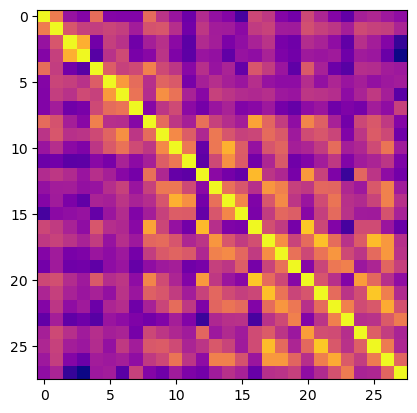

In [161]:
combined_cov = covhigh+covlow
corr_matrix = np.zeros((len(covhigh),len(covhigh)))
for i in range(len(covhigh)):
    for j in range(len(covhigh)):
        corr_matrix[i,j] = (combined_cov[i,j])/(math.sqrt(combined_cov[i,i]*combined_cov[j,j]))
        
plt.imshow(corr_matrix, cmap = 'plasma')

In [162]:
print("high: " , conditionhigh)
print("low: " , conditionlow)
print("condition number: " , conditioncombined)
print("Twice inverted/original test: ")
print(invertest[0])
# print(errhigh)
print()
print(outputlow)

high:  3072410.268183347
low:  365005.8758065415
condition number:  4417.638725351623
Twice inverted/original test: 
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]

[[0.3125     0.52083331 0.75       0.79166669]
 [0.21153846 0.36538461 0.55769229 0.80769229]
 [0.09090909 0.23636363 0.5272727  0.81818181]
 [0.01724138 0.24137931 0.5        0.79310346]
 [0.03508772 0.22807017 0.50877196 0.80701756]
 [0.04918033 0.14754099 0.49180329 0.72131145]
 [0.01587302 0.20634921 0.3968254  0.76190478]]


In [163]:

# Define your cosmology parameters
# H0 = Hubble constant in km/s/Mpc, Om0 = Omega matter density parameter
# cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

# Specify the redshift you're interested in
z = np.median(agnmass['z'])

# Calculate the angular diameter distance for this redshift
D_A = cosmo.angular_diameter_distance(z)

# Convert the angular diameter distance to kpc (the default unit is Mpc)
D_A_kpc = D_A.to(u.kpc)

# To get the scale in kpc/degree, use the small angle approximation:
# s = D_A * (pi/180) * (1 degree in radians) * 1000 (to convert from Mpc to kpc)
# Note that Astropy handles units, so you don't need to manually convert degrees to radians
scale_kpc_per_degree = D_A_kpc * (u.degree.to(u.rad))

print(f"The scale is {scale_kpc_per_degree.value:.2f} kpc/degree at z={z}.")


The scale is 4748.78 kpc/degree at z=0.069.


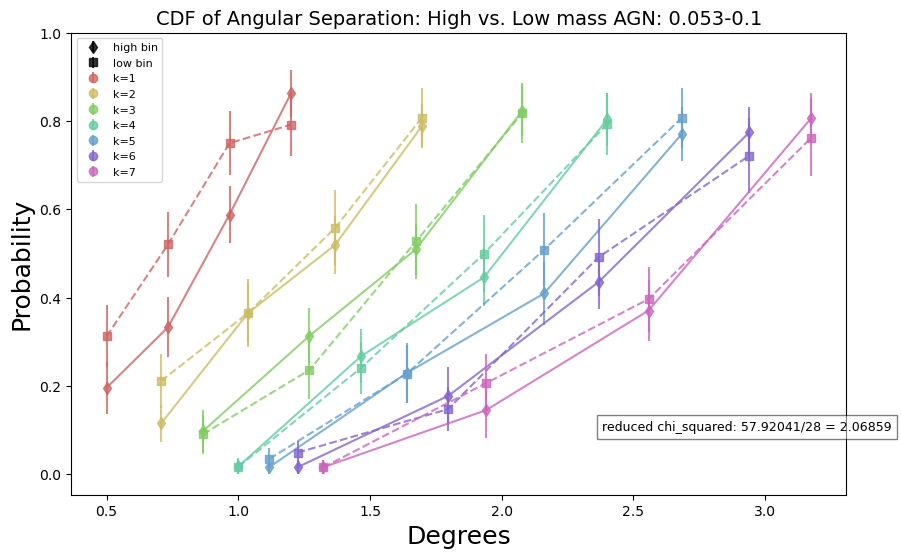

The scale is 4748.78 kpc/degree at z=0.069.


In [164]:
#Calculate relevant values
chi_squared = kNN_chi_squared(outputhigh,outputlow,covhigh,covlow,concatenate=True)
chi_strnew = 'reduced chi_squared: '+ str(round(chi_squared,5)) + '/'+ str(len(angles)*len(kneighbors)) + ' = ' + str(round(round(chi_squared,5)/(len(angles)*len(kneighbors)),5))

# Set up the main plot
fig, ax = plt.subplots(figsize=(10, 6))

# Customize the main plot
ax.set_ylabel('Probability', fontsize=18)
# ax.set_title('CDF of Angular Separation: High vs. Low mass AGN', fontsize=14)


ax.set_title('CDF of Angular Separation: High vs. Low mass AGN: ' + str(round(zmin,4)) + "-" + str(round(zmax,4)) , fontsize=14)
ax.set_xlabel('Degrees', fontsize=18)

colors = generate_distinct_colors(kneighbors[-1])  # Different color for each neighbor

legend_created = False;

for ind,neighbor in zip(np.arange(len(kneighbors)),kneighbors) :  
    anglemax = angles[-1] * 180/(math.pi) * np.sqrt(neighbor)
    anglemin = angles[0] * 180/(math.pi) * np.sqrt(neighbor)
    if ind == 0:
        scaled_angles = (angles - angleslist) * 180 / (math.pi) * math.pow(neighbor,1/2)
    else:
        scaled_angles = angles * 180 / (math.pi) * math.pow(neighbor,1/2)
    
    # Calculate relevant values for each neighbor
    differr = kNN_diff_error(outputhigh[ind], outputlow[ind], errhigh[ind], errlow[ind], single_neighbor=True)
    # Plot for each neighbor
        
    ax.errorbar(scaled_angles, outputhigh[ind], yerr=errhigh[ind], fmt='d', alpha=0.8, color=colors[neighbor-1])
    ax.errorbar(scaled_angles, outputlow[ind], yerr=errlow[ind], fmt='s', alpha=0.8, color=colors[neighbor-1])
    
    ax.plot(scaled_angles, outputhigh[ind], '-', alpha=0.8, color=colors[neighbor-1])
    ax.plot(scaled_angles, outputlow[ind], '--', alpha=0.8, color=colors[neighbor-1])
    if not legend_created:
        ax.errorbar([], [], yerr=[], fmt='d', alpha=0.8, color='black', label='high bin')
        ax.errorbar([], [], yerr=[], fmt='s', alpha=0.8, color='black', label='low bin')
        for i in kneighbors-1:
            ax.errorbar([], [], yerr=[], fmt='o', alpha=0.8, color=colors[i], label=f'k={i+1}')
        legend_created = True
        
ax.legend(loc='upper left', fontsize=8)
ax.set_yticks([0,0.2,0.4,0.6,0.8,1])
plt.text(anglemax-(.3*math.sqrt(kneighbors[-1])), 0.1, chi_strnew, fontsize=9,bbox = dict(facecolor = 'white', alpha = 0.5))
plt.show()

print(f"The scale is {scale_kpc_per_degree.value:.2f} kpc/degree at z={z}.")

NameError: name 'average_randoms' is not defined

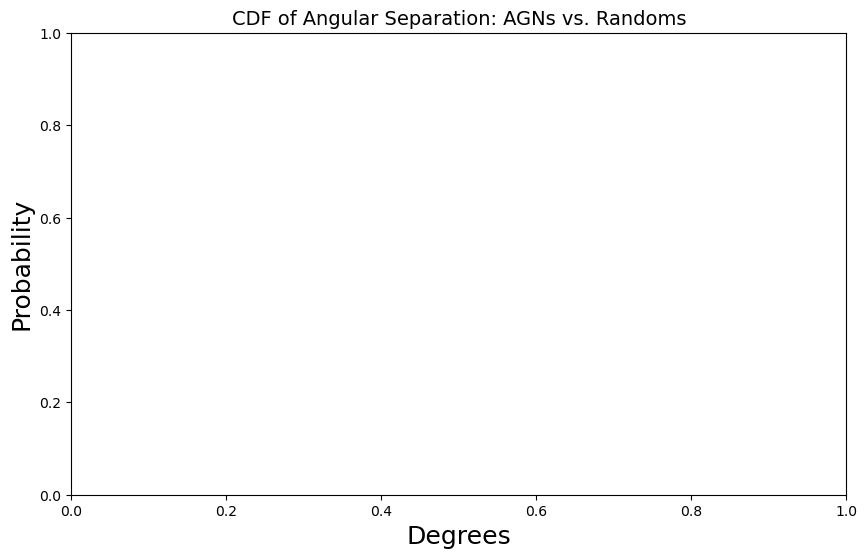

In [41]:


# Set up the main plot
fig, ax = plt.subplots(figsize=(10, 6))

# Customize the main plot
ax.set_ylabel('Probability', fontsize=18)
ax.set_title('CDF of Angular Separation: AGNs vs. Randoms', fontsize=14)
ax.set_xlabel('Degrees', fontsize=18)

colors = ['blue', 'green', 'red', 'purple']  # Different color for each neighbor

legend_created = False;

for neighbor in range(1, 5):  # Neighbors 1 through 4
    anglemax = angles[-1] * 180/(math.pi) * np.sqrt(neighbor)
    anglemin = angles[0] * 180/(math.pi) * np.sqrt(neighbor)
    ind = neighbor - 1
    
    differr = kNN_diff_error(outputhigh[ind], average_randoms[ind], errhigh[ind], average_randoms_err[ind], single_neighbor=True)


#     ax.errorbar(angles * 180/(math.pi) * np.sqrt(neighbor), outputhigh[ind], yerr=errhigh[ind], fmt='d', alpha=0.8, color=colors[neighbor-1])
#     ax.errorbar(angles * 180/(math.pi) * np.sqrt(neighbor), average_randoms[ind], yerr=average_randoms_err[ind], fmt='s', alpha=0.8, color=colors[neighbor-1])

    ax.errorbar(angles * 180/(math.pi) * np.sqrt(neighbor), outputhigh[ind]- average_randoms[ind], yerr=differr, fmt='d', alpha=0.8, color=colors[neighbor-1])
    
    if not legend_created:
#         ax.errorbar([], [], yerr=[], fmt='d', alpha=0.8, color='black', label='AGNs')
#         ax.errorbar([], [], yerr=[], fmt='s', alpha=0.8, color='black', label='Randoms')
        
        ax.errorbar([], [], yerr=[], fmt='d', alpha=0.8, color='black', label='AGNs - Randoms')
        legend_created = True

    
    
ax.legend(loc='upper left', fontsize=8)


plt.show()

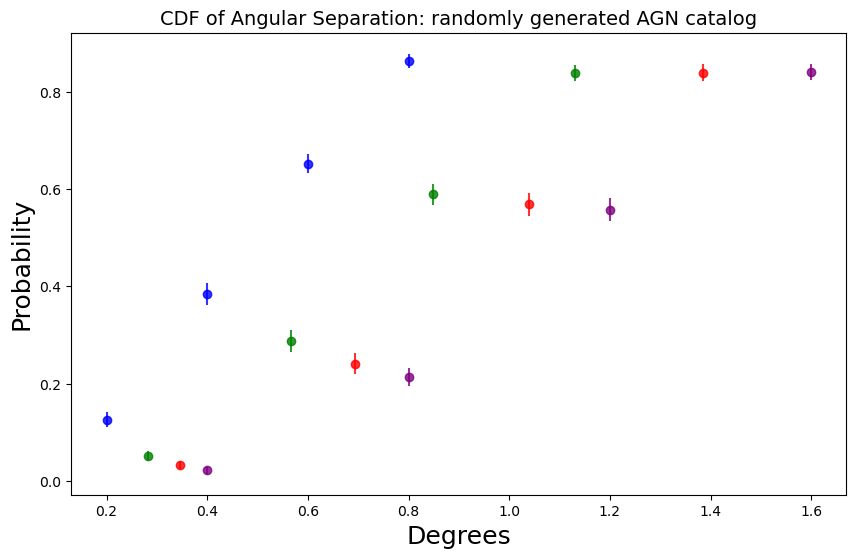

In [120]:


# Set up the main plot
fig, ax = plt.subplots(figsize=(10, 6))

# Customize the main plot
ax.set_ylabel('Probability', fontsize=18)
ax.set_title('CDF of Angular Separation: randomly generated AGN catalog', fontsize=14)
ax.set_xlabel('Degrees', fontsize=18)

stacked_randoms = np.stack((randoms1, randoms2, randoms3, randoms4, randoms5), axis=0)
average_randoms = np.mean(stacked_randoms, axis=0)

stacked_randoms_err = np.stack((randerr1, randerr2, randerr3, randerr4, randerr5), axis=0)
average_randoms_err = np.mean(stacked_randoms_err, axis=0)

colors = ['blue', 'green', 'red', 'purple']  # Different color for each neighbor

for neighbor in range(1, 5):  # Neighbors 1 through 4
    anglemax = angles[-1] * 180/(math.pi) * np.sqrt(neighbor)
    anglemin = angles[0] * 180/(math.pi) * np.sqrt(neighbor)
    ind = neighbor - 1
    
#     ax.errorbar(angles * 180/(math.pi) * np.sqrt(neighbor), randoms1[ind], yerr=randerr1[ind], fmt='o', label=f'k={neighbor}', alpha=0.8, color=colors[neighbor-1])
#     ax.errorbar(angles * 180/(math.pi) * np.sqrt(neighbor), randoms2[ind], yerr=randerr2[ind], fmt='o', label=f'k={neighbor}', alpha=0.8, color=colors[neighbor-1])
#     ax.errorbar(angles * 180/(math.pi) * np.sqrt(neighbor), randoms3[ind], yerr=randerr3[ind], fmt='o', label=f'k={neighbor}', alpha=0.8, color=colors[neighbor-1])
#     ax.errorbar(angles * 180/(math.pi) * np.sqrt(neighbor), randoms4[ind], yerr=randerr4[ind], fmt='o', label=f'k={neighbor}', alpha=0.8, color=colors[neighbor-1])
#     ax.errorbar(angles * 180/(math.pi) * np.sqrt(neighbor), randoms5[ind], yerr=randerr5[ind], fmt='o', label=f'k={neighbor}', alpha=0.8, color=colors[neighbor-1])

    #Average of these randoms
    ax.errorbar(angles * 180/(math.pi) * np.sqrt(neighbor), average_randoms[ind], yerr=average_randoms_err[ind], fmt='o', label=f'k={neighbor}', alpha=0.8, color=colors[neighbor-1])


    
    
# ax.legend(loc='upper left', fontsize=8)

# # Standard Deviation of randoms
# stacked_randoms = np.stack((randoms1, randoms2, randoms3, randoms4, randoms5), axis=0)
# std_deviation_across_runs = np.std(stacked_randoms, axis=0)
# flattened_results = std_deviation_across_runs.flatten()
# overall_std_deviation = np.std(flattened_results)
# print(overall_std_deviation)


plt.show()

[0.4 0.8 1.2 1.6]


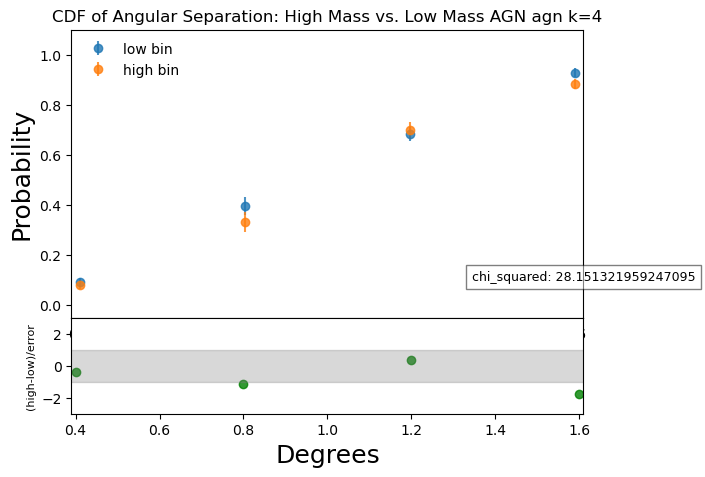

In [121]:
neighbor = 4

anglemax = angles[-1] * 180/(math.pi) * np.sqrt(neighbor)
anglemin = angles[0] * 180/(math.pi) * np.sqrt(neighbor)

ind = neighbor - 1

#Calculate relevant values
chi_squared = kNN_chi_squared(outputhigh,outputlow,covhigh,covlow,concatenate=True)
differr = kNN_diff_error(outputhigh[ind],outputlow[ind],errhigh[ind],errlow[ind],single_neighbor=True)
chi_strnew = 'chi_squared: '+ str(chi_squared)

#Main Plot
fig1 = plt.figure(1)
frame1=fig1.add_axes((.1,.3,.8,.6),yticks=[.0,.2,.4,.6,.8,1.0])
plt.errorbar(angles * 180/(np.pi) * np.sqrt(neighbor), outputlow[ind], yerr=errlow[ind],fmt='o',label='low bin',alpha=0.8)
plt.errorbar(angles * 180/(np.pi) * np.sqrt(neighbor), outputhigh[ind], yerr=errhigh[ind],fmt='o',label='high bin',alpha=0.8)
plt.ylabel('Probability',fontsize=18)
plt.legend(frameon=False,numpoints=1,loc=2)
plt.title('CDF of Angular Separation: High Mass vs. Low Mass AGN agn k=' + str(neighbor))
plt.axis([anglemin -.02, anglemax+.02,-.05,1.1])
plt.text(anglemax-.25, 0.1, chi_strnew, fontsize=9,bbox = dict(facecolor = 'white', alpha = 0.5))


#Subplot
frame2=fig1.add_axes((.1,.1,.8,.2),yticks=[-2,0,2])
plt.scatter(angles * 180/(np.pi) * np.sqrt(neighbor),(outputhigh[ind]-outputlow[ind])/differr,label='high-low',alpha=0.8, color = "green")
plt.fill_between([anglemin -.5, anglemax+.5], [1,1], [-1,-1],color='gray',alpha=0.3)
plt.ylabel('(high-low)/error',fontsize=8)
plt.axis([anglemin -.01, anglemax+.01,-3.01,3.01])
plt.xlabel('Degrees',fontsize=18)

print(angles * 180/(np.pi) * np.sqrt(neighbor))